<a href="https://colab.research.google.com/github/saksham20aggarwal/GANS/blob/main/cycle_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import glob
import time
import PIL.Image as Image
from tqdm.notebook import tqdm
from itertools import chain
from collections import OrderedDict
import random

import torch
import torch.nn as nn
import torchvision.utils as vutils
import torchvision.datasets as dset
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pylab as plt
import ipywidgets
from IPython import display
from tqdm.notebook import tqdm


In [ ]:
if not os.path.exists('./horse2zebra'):
  import gdown
  url = 'https://drive.google.com/uc?id=1jPelB2jzNZJq3ZU9Uk_Mkt4MJtF3DRgg'
  gdown.download(url, './horse2zebra.zip', quiet=False)
  !unzip ./horse2zebra.zip > /dev/null

Downloading...
From: https://drive.google.com/uc?id=1jPelB2jzNZJq3ZU9Uk_Mkt4MJtF3DRgg
To: /content/horse2zebra.zip
117MB [00:03, 38.2MB/s]


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [ ]:
import shutil, sys 
shutil.move("/content/horse2zebra/train/A", "/content/horses_train/A")
shutil.move("/content/horse2zebra/train/B", "/content/zebra_train/B")
shutil.move("/content/horse2zebra/test/A", "/content/horses_test/A")
shutil.move("/content/horse2zebra/test/B", "/content/zebra_test/B")

'/content/zebra_test/B'

In [ ]:
bs = 5
workers = 2
image_size = (256,256)

In [ ]:
def plot_images_test(dataloader_test_horses, dataloader_zebra_test): 
    batch_a_test = next(iter(dataloader_test_horses))[0].to(device)
    real_a_test = batch_a_test.cpu().detach()
    fake_b_test = G_A2B(batch_a_test ).cpu().detach()


    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((real_a_test[:4]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real horses")
    plt.show()

          
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((fake_b_test[:4]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake zebras")
    plt.show()


    batch_b_test = next(iter(dataloader_zebra_test))[0].to(device)
    real_b_test = batch_b_test.cpu().detach()
    fake_a_test = G_B2A(batch_b_test ).cpu().detach()
    
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((real_b_test[:4]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Real zebras")
    plt.show()


    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(vutils.make_grid((fake_a_test[:4]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("Fake horses")
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
norm_layer = nn.InstanceNorm2d
class ResBlock(nn.Module):
    def __init__(self, f):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(f, f, 3, 1, 1), norm_layer(f), nn.ReLU(),
                                  nn.Conv2d(f, f, 3, 1, 1))
        self.norm = norm_layer(f)
    def forward(self, x):
        return F.relu(self.norm(self.conv(x)+x))

class Generator(nn.Module):
    def __init__(self, f=64, blocks=9):
        super(Generator, self).__init__()
        layers = [nn.ReflectionPad2d(3),
                  nn.Conv2d(  3,   f, 7, 1, 0), norm_layer(  f), nn.ReLU(True),
                  nn.Conv2d(  f, 2*f, 3, 2, 1), norm_layer(2*f), nn.ReLU(True),
                  nn.Conv2d(2*f, 4*f, 3, 2, 1), norm_layer(4*f), nn.ReLU(True)]
        for i in range(int(blocks)):
            layers.append(ResBlock(4*f))
        layers.extend([
                nn.ConvTranspose2d(4*f, 4*2*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(2*f), nn.ReLU(True),
                nn.ConvTranspose2d(2*f,   4*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(  f), nn.ReLU(True),
                nn.ReflectionPad2d(3), nn.Conv2d(f, 3, 7, 1, 0),
                nn.Tanh()])
        self.conv = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.conv(x)

In [ ]:
nc=3
ndf=64
class Discriminator(nn.Module):  
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc,ndf,4,2,1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf,ndf*2,4,2,1, bias=False),
            nn.InstanceNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf*4,ndf*8,4,1,1),
            nn.InstanceNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 15 x 15
            nn.Conv2d(ndf*8,1,4,1,1)
            # state size. 1 x 14 x 14
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
def LSGAN_D(real, fake):
  return (torch.mean((real - 1)**2) + torch.mean(fake**2))

def LSGAN_G(fake):
  return  torch.mean((fake - 1)**2)

In [ ]:
G_A2B = Generator().to(device)
G_B2A = Generator().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

# Initialize Loss function
criterion_Im = torch.nn.L1Loss() 

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Optimizers

In [ ]:
def training(G_A2B, G_B2A, D_A, D_B,num_epochs,name,old = True):

  

  # Training Loop

  # Lists to keep track of progress
  img_list = []
  G_losses = []
  D_A_losses = []
  D_B_losses = []


  iters=0
  FDL_A2B = []
  FDL_B2A = []
  CL_A = []
  CL_B = []
  ID_B2A = []
  ID_A2B = []
  disc_A = []
  disc_B = []


  FDL_A2B_t = []
  FDL_B2A_t = []
  CL_A_t = []
  CL_B_t = []
  ID_B2A_t = []
  ID_A2B_t = []
  disc_A_t = []
  disc_B_t = []

  print("Starting Training Loop...")
  # For each epoch
  for epoch in range(num_epochs):

    # For each batch in the dataloader
    for  i,(data_horse, data_zebra) in enumerate(zip(dataloader_train_horses, dataloader_zebra_train),0):
    
        # Set model input
        a_real = data_horse[0].to(device)
        b_real = data_zebra[0].to(device)
      
        tensor_ones=torch.ones([a_real.shape[0],1,14,14]).cuda()
        tensor_zeros=torch.zeros([a_real.shape[0],1,14,14]).cuda()

        # Genrated images
        b_fake = G_A2B(a_real)
        a_rec = G_B2A(b_fake)
        a_fake = G_B2A(b_real)
        b_rec = G_A2B(a_fake)


        # Discriminator A
        optimizer_D_A.zero_grad()
        if((iters > 0 or epoch > 0) and old and iters % 3 == 0):
          rand_int = random.randint(5, old_a_fake.shape[0]-1)
          Disc_loss_A = LSGAN_D(D_A(a_real), D_A(old_a_fake[rand_int-5:rand_int].detach()))
          D_A_losses.append(Disc_loss_A.item())

        else:
          Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
          D_A_losses.append(Disc_loss_A.item())
        
        Disc_loss_A.backward()
        optimizer_D_A.step()

        
        # Discriminator B

        optimizer_D_B.zero_grad()
        if((iters > 0 or epoch > 0) and old and iters % 3 == 0):
          rand_int = random.randint(5, old_b_fake.shape[0]-1)
          Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(old_b_fake[rand_int-5:rand_int].detach()))
          D_B_losses.append(Disc_loss_B.item())
        else:
          Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(b_fake.detach()))
          D_B_losses.append(Disc_loss_B.item())

        Disc_loss_B.backward()
        optimizer_D_B.step()   

        # Generator

        optimizer_G_A2B.zero_grad()
        optimizer_G_B2A.zero_grad()


        # Fool discriminator
        Fool_disc_loss_A2B = LSGAN_G(D_B(b_fake))
        Fool_disc_loss_B2A = LSGAN_G(D_A(a_fake))

        # Cycle Consistency    both use the two generators
        Cycle_loss_A = criterion_Im(a_rec, a_real)*5
        Cycle_loss_B = criterion_Im(b_rec, b_real)*5

        # Identity loss
        Id_loss_B2A = criterion_Im(G_B2A(a_real), a_real)*10
        Id_loss_A2B = criterion_Im(G_A2B(b_real), b_real)*10

        # generator losses


        Loss_G = Fool_disc_loss_A2B+Fool_disc_loss_B2A+Cycle_loss_A+Cycle_loss_B+Id_loss_B2A+Id_loss_A2B
        G_losses.append(Loss_G)

        # Backward propagation
        Loss_G.backward()
        
        
        # Optimisation step
        optimizer_G_A2B.step()
        optimizer_G_B2A.step()

        FDL_A2B.append(Fool_disc_loss_A2B)
        FDL_B2A.append(Fool_disc_loss_B2A)
        CL_A.append(Cycle_loss_A)
        CL_B.append(Cycle_loss_B)
        ID_B2A.append(Id_loss_B2A)
        ID_A2B.append(Id_loss_A2B)
        disc_A.append(Disc_loss_A)
        disc_B.append(Disc_loss_B)

        if(iters == 0 and epoch == 0):
          old_b_fake = b_fake.clone()
          old_a_fake = a_fake.clone()
        elif (old_b_fake.shape[0] == bs*5 and b_fake.shape[0]==bs):
          rand_int = random.randint(5, 24)
          old_b_fake[rand_int-5:rand_int] = b_fake.clone()
          old_a_fake[rand_int-5:rand_int] = a_fake.clone()
        elif(old_b_fake.shape[0]< 25):
          old_b_fake = torch.cat((b_fake.clone(),old_b_fake))
          old_a_fake = torch.cat((a_fake.clone(),old_a_fake))

        iters += 1
        del data_zebra, data_horse, a_real, b_real, a_fake, b_fake


        if iters % 50 == 0:
      
          print('[%d/%d]\tFDL_A2B: %.4f\tFDL_B2A: %.4f\tCL_A: %.4f\tCL_B: %.4f\tID_B2A: %.4f\tID_A2B: %.4f\tLoss_D_A: %.4f\tLoss_D_A: %.4f'
                      % (epoch+1, num_epochs, Fool_disc_loss_A2B, Fool_disc_loss_B2A,Cycle_loss_A,Cycle_loss_B,Id_loss_B2A,
                          Id_loss_A2B, Disc_loss_A.item(), Disc_loss_B.item()))
        

    FDL_A2B_t.append(sum(FDL_A2B)/len(FDL_A2B))
    FDL_B2A_t.append(sum(FDL_B2A)/len(FDL_B2A))
    CL_A_t.append(sum(CL_A)/len(CL_A))
    CL_B_t.append(sum(CL_B)/len(CL_B))
    ID_B2A_t.append(sum(ID_B2A)/len(ID_B2A))
    ID_A2B_t.append(sum(ID_A2B)/len(ID_A2B))
    disc_A_t.append(sum(disc_A)/len(disc_A))
    disc_B_t.append(sum(disc_B)/len(disc_B))

    FDL_A2B = []
    FDL_B2A = []
    CL_A = []
    CL_B = []
    ID_B2A = []
    ID_A2B = []
    disc_B = []
    disc_A = []

    iters = 0             
    # save_models(G_A2B, G_B2A, D_A, D_B, name)
    if (epoch % 5 == 0):
      plot_images_test(dataloader_test_horses, dataloader_zebra_test)
    #plot_all_images(4, dataloader_test_horses, dataloader_zebra_test)
  return(FDL_A2B_t,FDL_B2A_t,CL_A_t,CL_B_t,ID_B2A_t,ID_A2B_t,disc_A_t,disc_B_t)

Starting Training Loop...
[1/20]	FDL_A2B: 0.5412	FDL_B2A: 0.3257	CL_A: 0.6809	CL_B: 0.6241	ID_B2A: 1.0053	ID_A2B: 1.1475	Loss_D_A: 0.4666	Loss_D_A: 0.4466
[1/20]	FDL_A2B: 0.2856	FDL_B2A: 0.3182	CL_A: 0.4618	CL_B: 0.4842	ID_B2A: 0.9071	ID_A2B: 0.9343	Loss_D_A: 0.4812	Loss_D_A: 0.4054
[1/20]	FDL_A2B: 0.4072	FDL_B2A: 0.5751	CL_A: 0.5122	CL_B: 0.5526	ID_B2A: 0.9530	ID_A2B: 1.0260	Loss_D_A: 0.5108	Loss_D_A: 0.4522
[1/20]	FDL_A2B: 0.3486	FDL_B2A: 0.3946	CL_A: 0.5753	CL_B: 0.6346	ID_B2A: 0.9176	ID_A2B: 1.1664	Loss_D_A: 0.6547	Loss_D_A: 0.5527


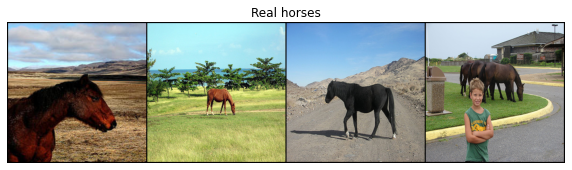

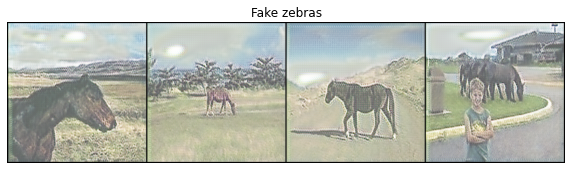

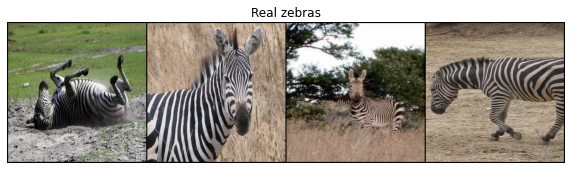

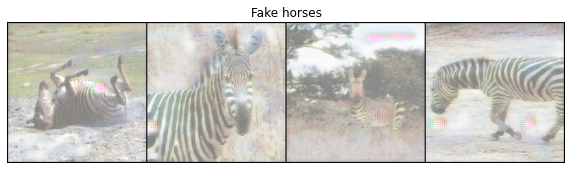

[2/20]	FDL_A2B: 0.3555	FDL_B2A: 0.3596	CL_A: 0.4823	CL_B: 0.5244	ID_B2A: 1.0019	ID_A2B: 0.8701	Loss_D_A: 0.5759	Loss_D_A: 0.5120
[2/20]	FDL_A2B: 0.2648	FDL_B2A: 0.2671	CL_A: 0.4570	CL_B: 0.5462	ID_B2A: 0.7324	ID_A2B: 0.9962	Loss_D_A: 0.3735	Loss_D_A: 0.3423
[2/20]	FDL_A2B: 0.3866	FDL_B2A: 0.4978	CL_A: 0.5098	CL_B: 0.5365	ID_B2A: 0.8793	ID_A2B: 0.9308	Loss_D_A: 0.4920	Loss_D_A: 0.2969
[2/20]	FDL_A2B: 0.3383	FDL_B2A: 0.3274	CL_A: 0.6700	CL_B: 0.5712	ID_B2A: 1.3113	ID_A2B: 1.0634	Loss_D_A: 0.5606	Loss_D_A: 0.5333
[3/20]	FDL_A2B: 0.3263	FDL_B2A: 0.2067	CL_A: 0.4839	CL_B: 0.6471	ID_B2A: 0.9979	ID_A2B: 1.1927	Loss_D_A: 0.5547	Loss_D_A: 0.6367
[3/20]	FDL_A2B: 0.3609	FDL_B2A: 0.1786	CL_A: 0.4884	CL_B: 0.6112	ID_B2A: 0.9321	ID_A2B: 0.8590	Loss_D_A: 0.3318	Loss_D_A: 0.3723
[3/20]	FDL_A2B: 0.2855	FDL_B2A: 0.1864	CL_A: 0.6036	CL_B: 0.5540	ID_B2A: 1.1270	ID_A2B: 0.8924	Loss_D_A: 0.7810	Loss_D_A: 0.8872
[3/20]	FDL_A2B: 0.3975	FDL_B2A: 0.2524	CL_A: 0.4601	CL_B: 0.4579	ID_B2A: 0.8094	ID_A2B: 0.8738	Lo

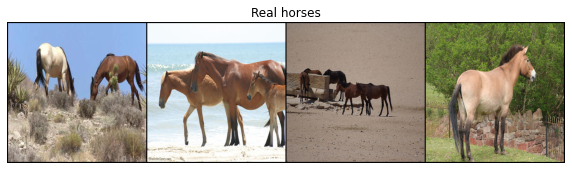

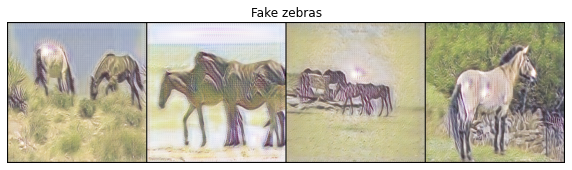

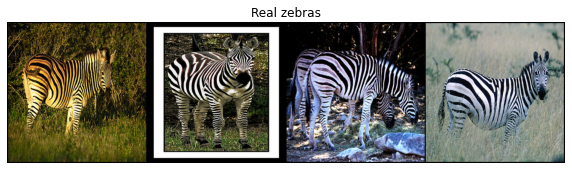

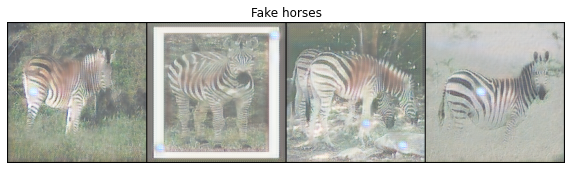

[7/20]	FDL_A2B: 0.4708	FDL_B2A: 0.2457	CL_A: 0.4494	CL_B: 0.5740	ID_B2A: 0.6849	ID_A2B: 1.1139	Loss_D_A: 0.4986	Loss_D_A: 0.4598
[7/20]	FDL_A2B: 0.3166	FDL_B2A: 0.2976	CL_A: 0.5259	CL_B: 0.5261	ID_B2A: 0.7795	ID_A2B: 0.8960	Loss_D_A: 0.3727	Loss_D_A: 0.4463
[7/20]	FDL_A2B: 0.4891	FDL_B2A: 0.3080	CL_A: 0.5924	CL_B: 0.5256	ID_B2A: 1.0071	ID_A2B: 0.9668	Loss_D_A: 0.5115	Loss_D_A: 0.3323
[7/20]	FDL_A2B: 0.3859	FDL_B2A: 0.4291	CL_A: 0.4150	CL_B: 0.4544	ID_B2A: 0.7061	ID_A2B: 0.8822	Loss_D_A: 0.5274	Loss_D_A: 0.3598
[8/20]	FDL_A2B: 0.3166	FDL_B2A: 0.4584	CL_A: 0.4364	CL_B: 0.4610	ID_B2A: 0.7740	ID_A2B: 0.7983	Loss_D_A: 0.4749	Loss_D_A: 0.4412
[8/20]	FDL_A2B: 0.3939	FDL_B2A: 0.4156	CL_A: 0.4322	CL_B: 0.4635	ID_B2A: 0.7233	ID_A2B: 0.8525	Loss_D_A: 0.3789	Loss_D_A: 0.4506
[8/20]	FDL_A2B: 0.5104	FDL_B2A: 0.3415	CL_A: 0.4479	CL_B: 0.4133	ID_B2A: 0.7624	ID_A2B: 0.7711	Loss_D_A: 0.4422	Loss_D_A: 0.3505
[8/20]	FDL_A2B: 0.5337	FDL_B2A: 0.6328	CL_A: 0.5570	CL_B: 0.5566	ID_B2A: 0.9166	ID_A2B: 0.9336	Lo

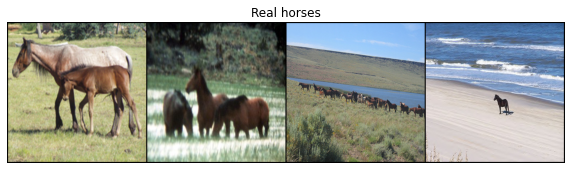

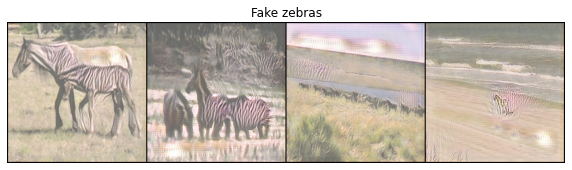

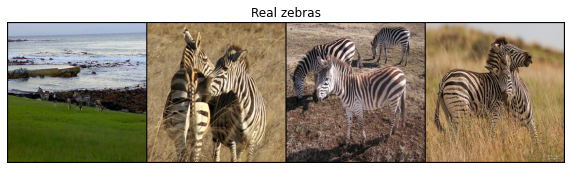

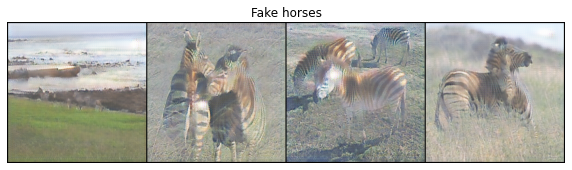

[12/20]	FDL_A2B: 0.5561	FDL_B2A: 0.2456	CL_A: 0.3856	CL_B: 0.5457	ID_B2A: 0.6659	ID_A2B: 0.8639	Loss_D_A: 0.4938	Loss_D_A: 0.3419
[12/20]	FDL_A2B: 0.2589	FDL_B2A: 0.4336	CL_A: 0.4185	CL_B: 0.4187	ID_B2A: 0.7380	ID_A2B: 0.7685	Loss_D_A: 0.4885	Loss_D_A: 0.3319
[12/20]	FDL_A2B: 0.5853	FDL_B2A: 0.7792	CL_A: 0.5735	CL_B: 0.4710	ID_B2A: 0.8825	ID_A2B: 0.8213	Loss_D_A: 0.2189	Loss_D_A: 0.3628
[12/20]	FDL_A2B: 0.4830	FDL_B2A: 0.2507	CL_A: 0.3830	CL_B: 0.4616	ID_B2A: 0.7036	ID_A2B: 0.8030	Loss_D_A: 0.4644	Loss_D_A: 0.4788
[13/20]	FDL_A2B: 0.4994	FDL_B2A: 0.3177	CL_A: 0.4915	CL_B: 0.4651	ID_B2A: 0.9650	ID_A2B: 0.8041	Loss_D_A: 0.7343	Loss_D_A: 0.7443
[13/20]	FDL_A2B: 0.1687	FDL_B2A: 0.1702	CL_A: 0.4209	CL_B: 0.4377	ID_B2A: 0.7343	ID_A2B: 0.7526	Loss_D_A: 0.5261	Loss_D_A: 0.4548
[13/20]	FDL_A2B: 0.5549	FDL_B2A: 0.4168	CL_A: 0.6387	CL_B: 0.6881	ID_B2A: 0.8858	ID_A2B: 0.9992	Loss_D_A: 0.3787	Loss_D_A: 0.3336
[13/20]	FDL_A2B: 0.4274	FDL_B2A: 0.3417	CL_A: 0.4313	CL_B: 0.5329	ID_B2A: 0.6952	ID_A2B: 0

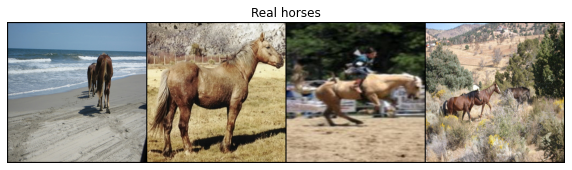

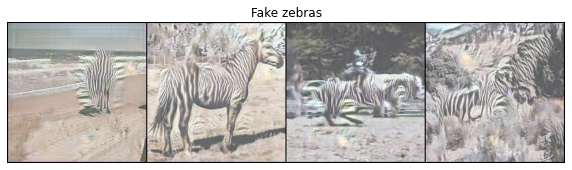

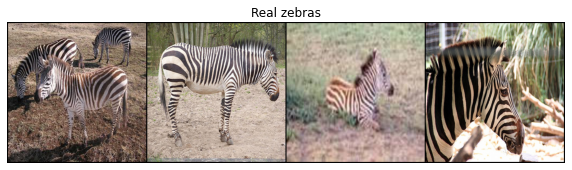

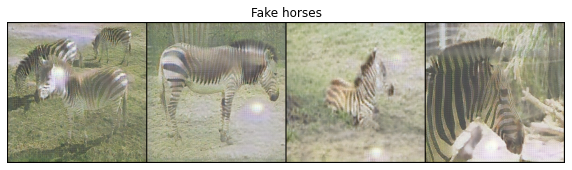

[17/20]	FDL_A2B: 0.3702	FDL_B2A: 0.3470	CL_A: 0.4095	CL_B: 0.3490	ID_B2A: 0.6808	ID_A2B: 0.5498	Loss_D_A: 0.5697	Loss_D_A: 0.4214
[17/20]	FDL_A2B: 0.2051	FDL_B2A: 0.3195	CL_A: 0.4634	CL_B: 0.4802	ID_B2A: 0.6596	ID_A2B: 0.8132	Loss_D_A: 0.3153	Loss_D_A: 0.3071
[17/20]	FDL_A2B: 0.6668	FDL_B2A: 0.3949	CL_A: 0.4704	CL_B: 0.4664	ID_B2A: 0.7203	ID_A2B: 0.7638	Loss_D_A: 0.4470	Loss_D_A: 0.7263
[17/20]	FDL_A2B: 0.5438	FDL_B2A: 0.3815	CL_A: 0.3863	CL_B: 0.4516	ID_B2A: 0.6343	ID_A2B: 0.6165	Loss_D_A: 0.4526	Loss_D_A: 0.4304
[18/20]	FDL_A2B: 0.6486	FDL_B2A: 0.4545	CL_A: 0.3645	CL_B: 0.4599	ID_B2A: 0.5373	ID_A2B: 0.7648	Loss_D_A: 0.5271	Loss_D_A: 0.3772
[18/20]	FDL_A2B: 0.2486	FDL_B2A: 0.3984	CL_A: 0.5638	CL_B: 0.3768	ID_B2A: 0.6969	ID_A2B: 0.6605	Loss_D_A: 0.4325	Loss_D_A: 0.3795
[18/20]	FDL_A2B: 0.3921	FDL_B2A: 0.3921	CL_A: 0.4049	CL_B: 0.4210	ID_B2A: 0.8055	ID_A2B: 0.7752	Loss_D_A: 0.5275	Loss_D_A: 0.5905
[18/20]	FDL_A2B: 0.5115	FDL_B2A: 0.3473	CL_A: 0.3751	CL_B: 0.4958	ID_B2A: 0.6701	ID_A2B: 0

In [ ]:
name="Basic9_old_256_training50"
#name="Basic9_training50"
#name = 'basic_training50'
epochs=20
netG_A2B, netG_B2A, netD_A, netD_B=G_A2B, G_B2A, D_A, D_B

optimizer_G_A2B = torch.optim.Adam(G_A2B.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G_B2A = torch.optim.Adam(G_B2A.parameters(), lr=lr, betas=(beta1, 0.999))

optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(beta1, 0.999))

losses = training( netG_A2B, netG_B2A, netD_A, netD_B,epochs,name)

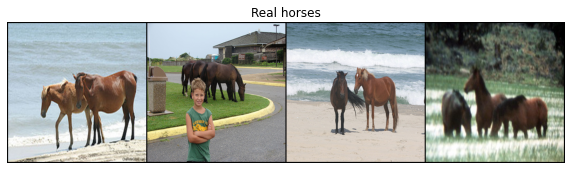

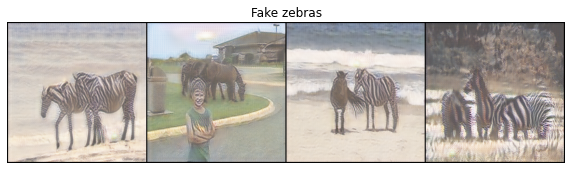

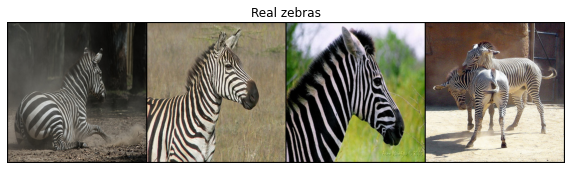

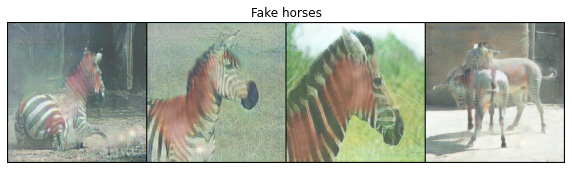

In [ ]:
plot_images_test(dataloader_test_horses, dataloader_zebra_test)
